
This tutorial runs the core-shell model for phase transition caused PE
(NMC811) degradation, based on the paper
-- Mingzhao Zhuo, Gregory Offer, Monica Marinescu, "Degradation model of
   high-nickel positive electrodes: Effects of loss of active material and
   cyclable lithium on capacity fade", Journal of Power Sources,
   556 (2023): 232461. doi: 10.1016/j.jpowsour.2022.232461.
The following scripts reproduce the results presented in Figs. 5, 7, 9 etc.
c_s: Trapped lithium concentration in the shell [mol.m-3]
rho: Positive electrode shell resistivity [Ohm.m]
Fig. 5: c_s = 14802, rho = 0
Fig. 7: c_s = 20000, rho = 0
Fig. 9: c_s = 20000, rho = 1e6
**

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = pybamm.lithium_ion.SPM({"PE degradation": "phase transition"})
param = pybamm.ParameterValues("Zhuo2023")
experiment = pybamm.Experiment(
    [
        (
            "Charge at 0.5 C until 4.2 V",
            "Hold at 4.2 V until C/50",
            "Rest for 60 minutes",
            "Discharge at 0.5 C until 2.8 V",
            "Hold at 2.8 V until C/50",
            "Rest for 60 minutes",
        )
    ]
    * 20,
)
sim = pybamm.Simulation(
    model,
    experiment=experiment,
    parameter_values=param,
)

In [3]:
solution = sim.solve(calc_esoh=False)

In [4]:
output_variables = [
    "X-averaged positive particle moving phase boundary location",
    "X-averaged positive electrode shell layer overpotential [V]",
    # "X-averaged loss of active material due to PE phase transition",
    "LLI_cyc [%]",
    "Cell SoC",
    [
        "Total cyclable lithium in primary phase in positive electrode [mol]",
        "Total cyclable lithium in primary phase in negative electrode [mol]",
        "Total cyclable lithium in particles [mol]",
    ],
    [
        "X-averaged positive core surface lithium concentration",
        "X-averaged negative particle surface concentration",
    ],
    # "Current [A]",
    # "Terminal voltage [V]",
    # "X-averaged negative particle concentration [mol.m-3]",
    # "X-averaged positive core lithium concentration [mol.m-3]",
    # "X-averaged positive shell oxygen concentration [mol.m-3]",
    # "LLI [%]",
]
sim.plot(output_variables, time_unit="hours")

interactive(children=(FloatSlider(value=0.0, description='t', max=118.65249350874537, step=1.1865249350874536)…

In [6]:
# task: post-processing - adjust to make the cell degrade to a reasonable value
variables = [
    "Discharge capacity [A.h]",
    #"Positive electrode capacity [A.h]",
    #"Negative electrode capacity [A.h]",
    "Loss of capacity to negative SEI [A.h]",
    "Total lithium capacity in particles [A.h]",
    #"Loss of capacity to negative SEI on cracks [A.h]",
    # "Loss of capacity to lithium plating [A.h]",
    # "X-averaged positive particle moving phase boundary location",
    "X-averaged loss of active material due to PE phase transition",
    "X-averaged positive electrode shell layer overpotential [V]",
    "Positive electrode stoichiometry",
    "Negative electrode stoichiometry",
]
Short_ylabel ={
    "Discharge capacity [A.h]": "Cap / A.h" ,
    "Loss of capacity to negative SEI [A.h]": "LLI to SEI / A.h",
    "Total lithium capacity in particles [A.h]": "Li in Particle / A.h" ,

    "X-averaged loss of active material due to PE phase transition": "LAM PE to Phase change / A.h" ,
    "X-averaged positive electrode shell layer overpotential [V]": "eta PE shell / V",
    "Positive electrode stoichiometry Start": "PE Sto Start" ,
    "Negative electrode stoichiometry Start": "NE Sto Start" ,
    "Positive electrode stoichiometry End": "PE Sto End" ,
    "Negative electrode stoichiometry End": "NE Sto End" ,
}
def Get_Summary_Dict_from_Sol(solution,variables,step_DC):
    Sol_dict = {}
    total_cycles = len(solution.cycles)
    cycle_numbers = np.arange(1, total_cycles+1)
    Sol_dict["Cyc No."] = cycle_numbers
    for var in variables:
        
        if var in ["Discharge capacity [A.h]"]:
            Sol_dict[var] = []
            for i in range(total_cycles):
                Q_dis_cyc = solution.cycles[i].steps[3]["Discharge capacity [A.h]"].entries
                Q_dis = abs(Q_dis_cyc[-1] - Q_dis_cyc[0])
                Sol_dict[var].append(Q_dis)
        elif var in ["Positive electrode stoichiometry","Negative electrode stoichiometry"]:
            Sol_dict[var + " Start"] = []
            Sol_dict[var + " End"] = []
            for i in range(total_cycles):
                Sol_dict[var + " Start"].append(
                    solution.cycles[i].steps[step_DC][var].entries[0])
                Sol_dict[var + " End"].append(
                    solution.cycles[i].steps[step_DC][var].entries[-1])
        else:
            Sol_dict[var] = []
            for i in range(total_cycles):
                Sol_dict[var].append(
                    solution.cycles[i][var].entries[0]
                )
    return Sol_dict
Sol_dict = Get_Summary_Dict_from_Sol(solution, variables, step_DC=3)

In [7]:
import matplotlib as mpl; 
fs=17
font = {'family' : 'DejaVu Sans',  'size'   : fs}
mpl.rc('font', **font)

import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
Save_fig_path = str_path_0 + "/examples/Reproduce_Pe_degrade_paper"

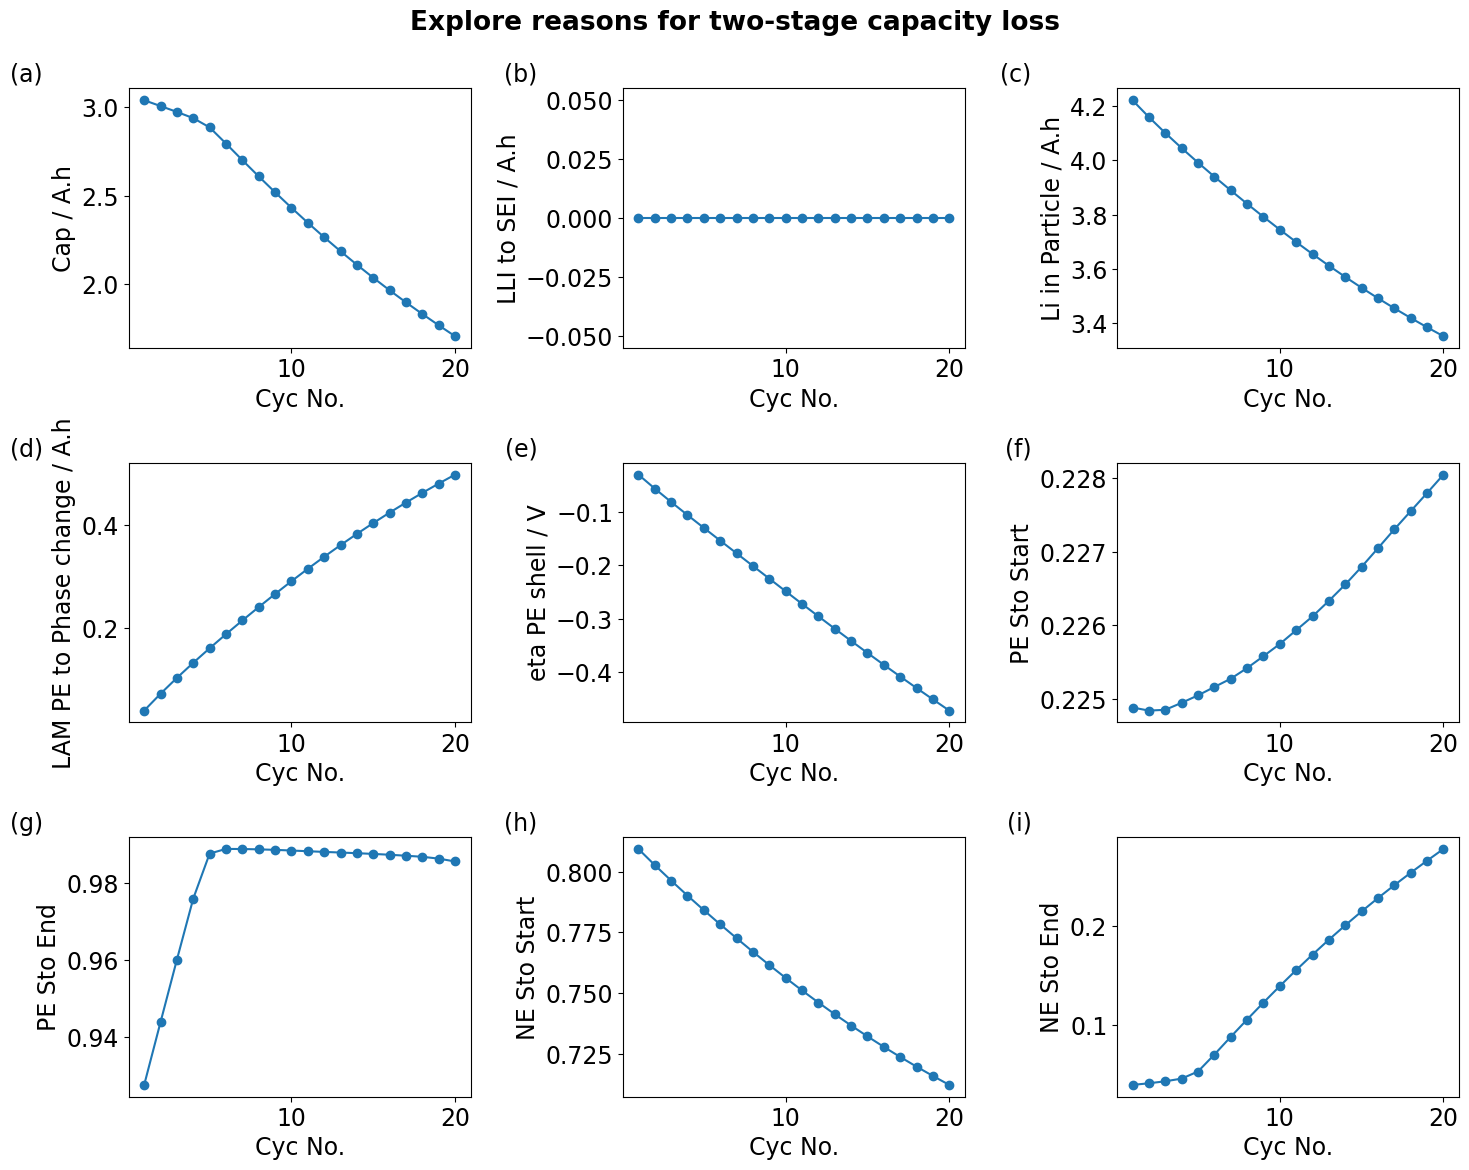

In [20]:
# plot and save figures
def Plot_Summary(Sol_dict, axs, labels):
    variables = Sol_dict.keys()
    i = 0
    for var in variables:
        if var in ["Cyc No."]:
            pass
        else:
            axs[i].plot(Sol_dict["Cyc No."],Sol_dict[var],"-o")
            axs[i].set_ylabel(Short_ylabel[var])
            axs[i].set_xlabel("Cyc No.")
            axs[i].text(
                -0.25, 1.1, 
                labels[i], transform=axs[i].transAxes, 
                fontsize=fs,  # fontweight='bold', 
                va='top', ha='right')
            i += 1
    return axs
labels = [
    "(a)", "(b)", "(c)", 
    "(d)", "(e)", "(f)", 
    "(g)", "(h)", "(i)", ]
fig, Axs = plt.subplots(3,3, figsize=(15,12),tight_layout=True)
axs = Axs.flatten()
axs = Plot_Summary(Sol_dict, axs, labels)
fig.suptitle(
    "Explore reasons for two-stage capacity loss", 
    fontsize=fs+2, fontweight='bold', )

fig.savefig(Save_fig_path + "/Explore reasons for two-stage capacity loss in Zhuo2023.svg")


In [19]:
import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
Save_fig_path = str_path_0 + "/examples/Reproduce_Pe_degrade_paper"